## 1. Listing the files in the dataset.

In [1]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 2. Importing required modules

In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [3]:
#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Using TensorFlow backend.


## 3. Preparing the data.
### 3.1 Making the functions to get the training and validation set from the Images

In [4]:
X=[]
Z=[]
IMG_SIZE=128
FLOWER_DAISY_DIR='../input/flowers-recognition/flowers/daisy'
FLOWER_SUNFLOWER_DIR='../input/flowers-recognition/flowers/sunflower'
FLOWER_TULIP_DIR='../input/flowers-recognition/flowers/tulip'
FLOWER_DANDI_DIR='../input/flowers-recognition/flowers/dandelion'
FLOWER_ROSE_DIR='../input/flowers-recognition/flowers/rose'

In [5]:
def assign_label(img,flower_type):
    return flower_type

In [6]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
            X.append(np.array(img))
            Z.append(str(label))
        

In [7]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 769/769 [00:03<00:00, 197.74it/s]

769


In [8]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 734/734 [00:03<00:00, 197.99it/s]

1503


In [9]:
make_train_data('tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:05<00:00, 185.58it/s]

2487


In [10]:
make_train_data('rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:03<00:00, 228.35it/s]

3271


In [11]:
make_train_data('dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1055/1055 [00:04<00:00, 225.26it/s]

4323


### 3.2 Visualizing random images

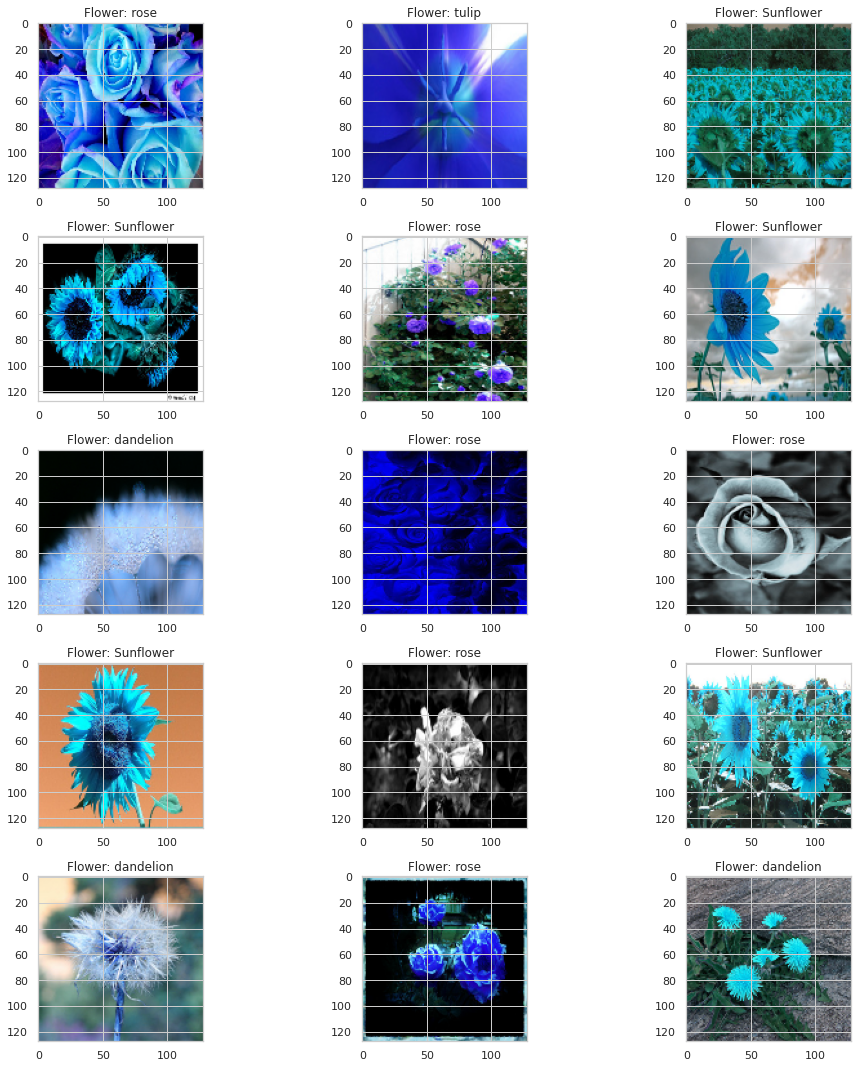

In [12]:
fig,ax=plt.subplots(5,3)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (3):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
 

### 3.3 Label Encoding the Y array (i.e. Daisy->0, Rose->1 etc...) & then One Hot Encoding

In [13]:
le = LabelEncoder()
Y = le.fit(Z)
Y = le.transform(Z)
Y = to_categorical(Y, 5)
X = np.array(X)
X = X / 255

### 3.4  Splitting into Training and Validation Sets

In [14]:
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.25, random_state=42)


In [15]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)

print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (3242, 128, 128, 3)
Shape of y_train: (3242, 5)
Shape of x_test: (1081, 128, 128, 3)
Shape of y_test: (1081, 5)


### 3.5 Setting the random seeds

In [16]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## 4. Building the Model
### 4.1 Specifying the AlexNet model in Keras

In [17]:
model = Sequential()

model.add(Conv2D(filters=96, kernel_size=(11,11),strides=(4,4), padding='valid', activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(5,5),strides=(1,1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=384, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

model.add(Conv2D(filters=384, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3),strides=(1,1), padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))

model.add(Flatten())

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(5, activation='softmax'))

### 4.2 Using Data Augmentation for Regularization

In [18]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

from keras.callbacks import ReduceLROnPlateau, EarlyStopping

red_lr = ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1)

early  = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')


### 4.3 Specifying the bacth size and epochs and then compiling the model.

In [19]:
batch_size=128
epochs=50
#model.compile(optimizer=SGD(lr=0.01, momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy']) # Original AlexNet Parameters
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

### 4.4 Model Summary

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 96)        34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 256)         1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 384)        

### 4.5 Training the model and making predictions on the validation set.

In [21]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs=epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 128, callbacks=[early])

Epoch 1/50
25/25 [==============================] - 15s 614ms/step - loss: 1.8211 - accuracy: 0.3044 - val_loss: 1.6360 - val_accuracy: 0.2340
Epoch 2/50
25/25 [==============================] - 12s 481ms/step - loss: 1.4065 - accuracy: 0.3719 - val_loss: 1.4812 - val_accuracy: 0.3506
Epoch 3/50
25/25 [==============================] - 12s 493ms/step - loss: 1.3596 - accuracy: 0.3854 - val_loss: 1.4675 - val_accuracy: 0.3571
Epoch 4/50
25/25 [==============================] - 13s 513ms/step - loss: 1.3443 - accuracy: 0.3805 - val_loss: 1.4743 - val_accuracy: 0.3386
Epoch 5/50
25/25 [==============================] - 13s 517ms/step - loss: 1.3150 - accuracy: 0.4059 - val_loss: 1.5414 - val_accuracy: 0.3284
Epoch 6/50
25/25 [==============================] - 12s 474ms/step - loss: 1.3356 - accuracy: 0.3920 - val_loss: 1.4789 - val_accuracy: 0.3191
Epoch 7/50
25/25 [==============================] - 12s 489ms/step - loss: 1.3087 - accuracy: 0.4141 - val_loss: 1.4250 - val_accuracy: 0.3654

## 5. Plotting and evaluating the model performance

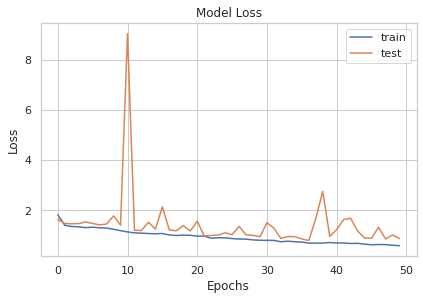

In [22]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

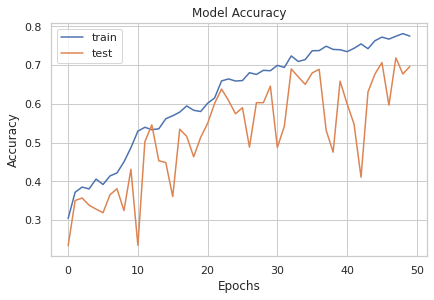

In [23]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

## 6. Visualizing Predictons on the Validation Set

In [24]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)
print(len(pred_digits))
print(pred_digits.shape)

print(y_test[0])



1081
(1081,)
[0. 1. 0. 0. 0.]


## 7. Calculating number of correctly and incorrectly classified number of images.****

In [25]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)

print("Number of correctly classified images: %d" %(len(prop_class)))
print("Number of incorrectly classified images: %d" %(len(mis_class)))

Number of correctly classified images: 753
Number of incorrectly classified images: 328


In [26]:
print(y_test[0])
(np.argmax(y_test,axis=1)).shape

[0. 1. 0. 0. 0.]


(1081,)

In [27]:
print(pred_digits.shape)
le.inverse_transform([pred_digits[prop_class[10]]])
le.inverse_transform(np.argmax(y_test,axis=1))

(1081,)


array(['Sunflower', 'Sunflower', 'Sunflower', ..., 'tulip', 'tulip',
       'rose'], dtype='<U9')

## 8. Correctly classified images visualized

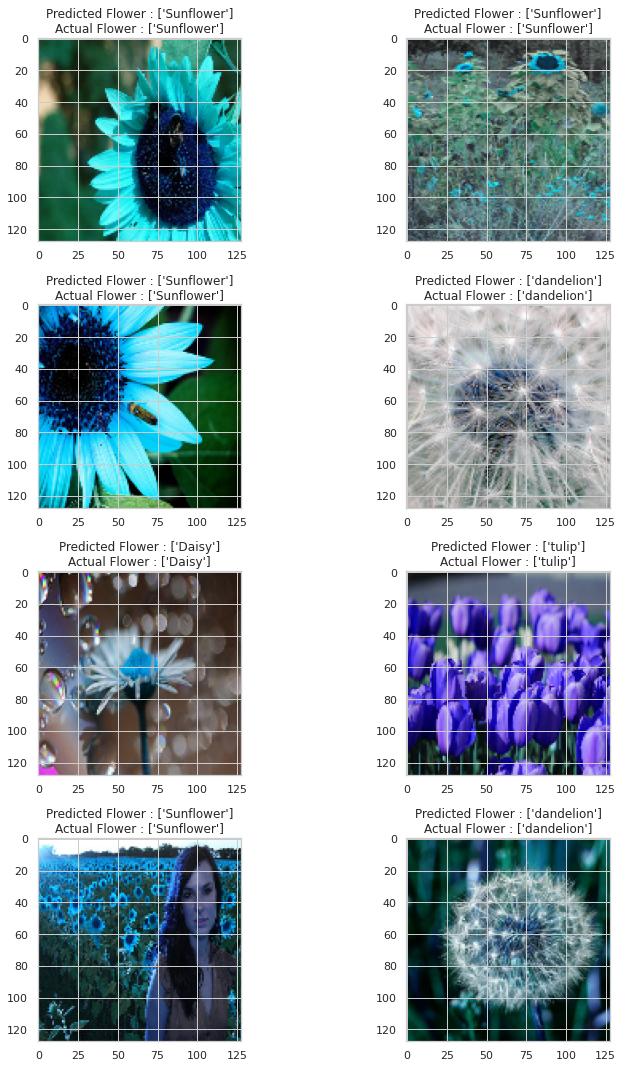

In [28]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]],axis=1))))
        plt.tight_layout()
        count+=1

## 9. Incorrectly classified images visualized

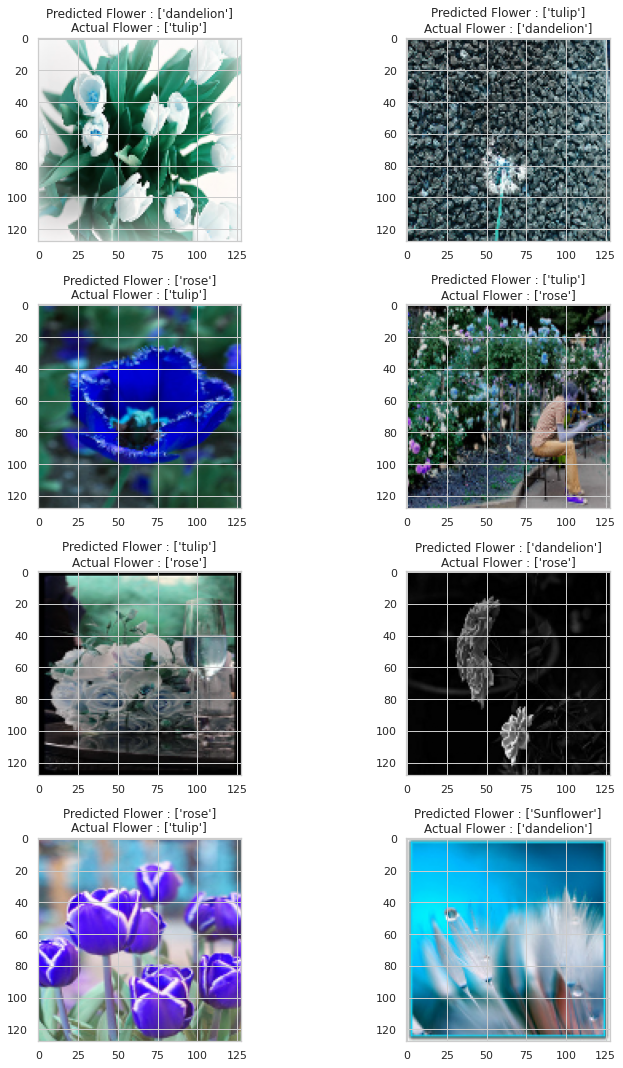

In [29]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]],axis=1))))
        plt.tight_layout()
        count+=1